In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from google.colab import files

# Upload dataset
uploaded = files.upload()
file_path = list(uploaded.keys())[0]


Saving marketing_campaign.csv to marketing_campaign (1).csv


2. Data Loading and Cleaning

In [6]:
# Read tab-separated dataset
df = pd.read_csv(file_path, sep='\t')

# Fill missing Income values
df['Income'].fillna(df['Income'].median(), inplace=True)

# Create derived features
df['Age'] = 2025 - df['Year_Birth']
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], dayfirst=True)
df['Customer_Lifetime'] = (pd.to_datetime('2025-01-01') - df['Dt_Customer']).dt.days
df['Dependents'] = df['Kidhome'] + df['Teenhome']

# Drop unnecessary columns
drop_cols = ['ID', 'Year_Birth', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'Kidhome', 'Teenhome']
df.drop(columns=drop_cols, inplace=True)

# Convert categorical columns to numeric
df = pd.get_dummies(df, columns=['Education', 'Marital_Status'], drop_first=True, dtype=int)

print("Data cleaned and features created!")


Data cleaned and features created!


/tmp/ipython-input-3729458865.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Income'].fillna(df['Income'].median(), inplace=True)


3. Data Visualization

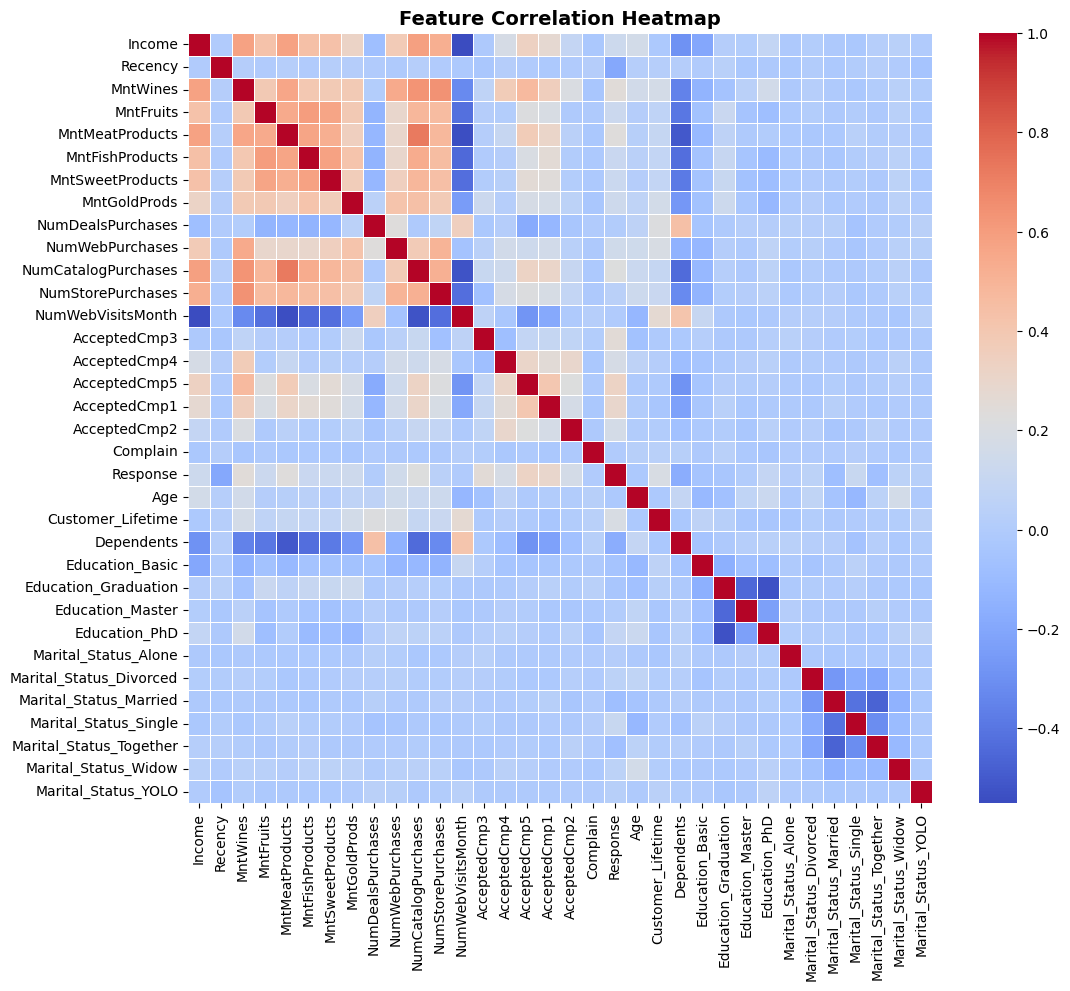

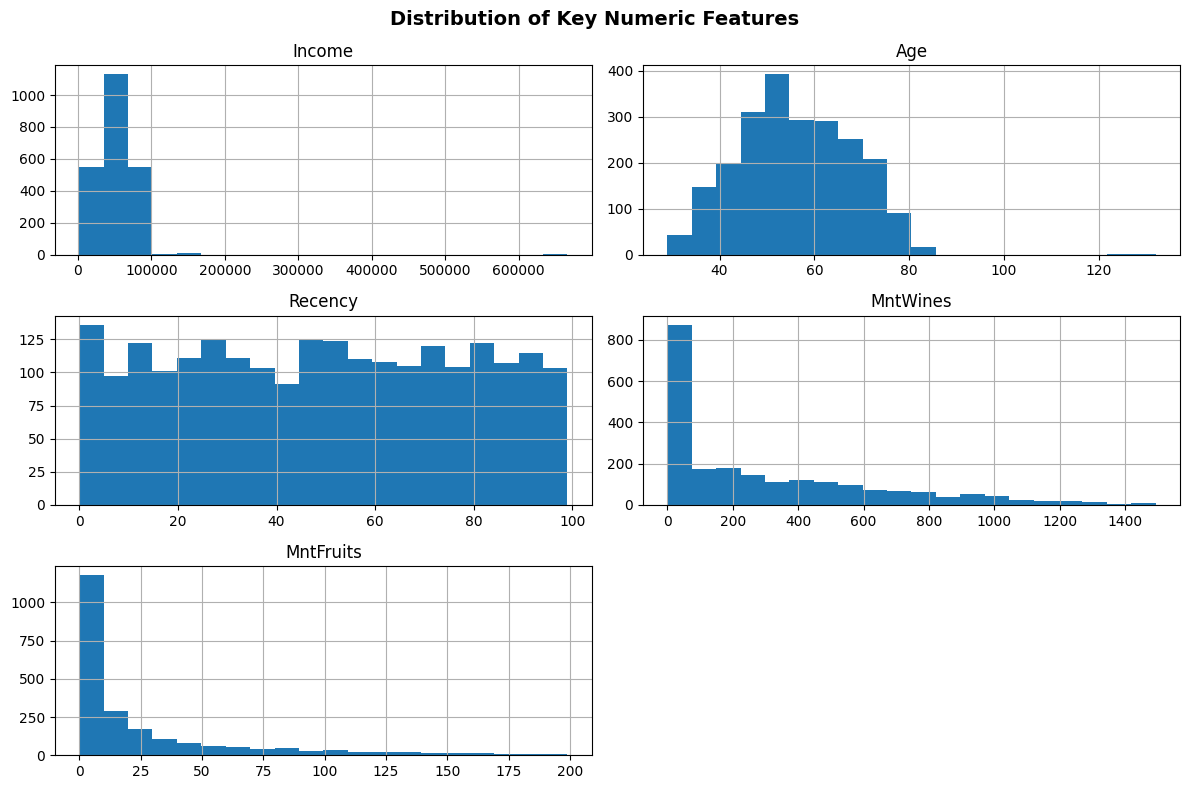

In [7]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=14, fontweight='bold')
plt.show()

# Histograms for numeric features
numeric_cols = ['Income', 'Age', 'Recency', 'MntWines', 'MntFruits']
df[numeric_cols].hist(figsize=(12, 8), bins=20)
plt.suptitle('Distribution of Key Numeric Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


4. PCA and K-Means Clustering

In [8]:
import numpy as np

# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Apply PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
reduced_data = pca.fit_transform(scaled_data)

# Find best k using Silhouette Score
sil_scores = []
k_range = range(2, 7)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(reduced_data)
    sil_scores.append(silhouette_score(reduced_data, labels))

# Select the k with the highest silhouette score
optimal_k = k_range[np.argmax(sil_scores)]
print(f"Optimal number of clusters (k): {optimal_k}")


✅ Optimal number of clusters (k): 2


5. Visualize Clusters

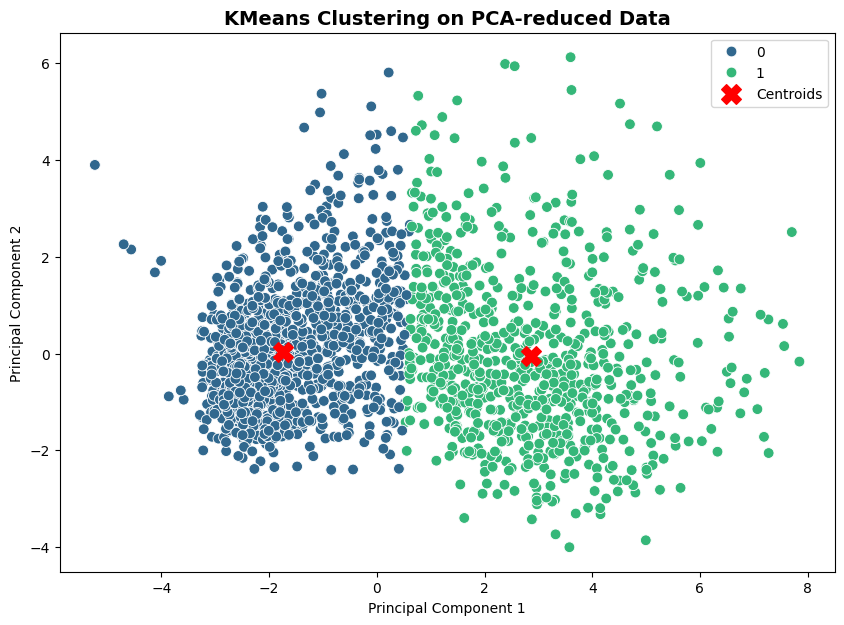

In [9]:
# Run KMeans with best k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(reduced_data)

# Scatter plot of clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=reduced_data[:, 0], y=reduced_data[:, 1],
    hue=df['Cluster'], palette='viridis', s=60
)
plt.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    c='red', marker='X', s=200, label='Centroids'
)
plt.title("KMeans Clustering on PCA-reduced Data", fontsize=14, fontweight='bold')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

## 6. Descriptive Stats + Tests

In [10]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import ttest_ind

# Show summary statistics
print("Descriptive Statistics:")
display(df.describe())

# Re-run PCA for analysis consistency
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
pca = PCA(n_components=2, random_state=42)
reduced_data = pca.fit_transform(scaled_data)

# Silhouette scores for different k
print("\n" + "="*50)
print("Silhouette Scores for Different Values of k")
print("="*50)
sil_scores = []
k_range = range(2, 7)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(reduced_data)
    score = silhouette_score(reduced_data, labels)
    sil_scores.append(score)
    print(f"Silhouette Score for k={k}: {score:.3f}")

optimal_k = k_range[np.argmax(sil_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")

# Final model and score
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(reduced_data)
final_silhouette = silhouette_score(reduced_data, df['Cluster'])
print(f"\nFinal Silhouette Score: {final_silhouette:.3f}")


Descriptive Statistics:


,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,...,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO,Cluster
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,52237.975446,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,...,0.165179,0.216964,0.001339,0.103571,0.385714,0.214286,0.258929,0.034375,0.000893,0.379018
std,25037.955891,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,...,0.371425,0.412270,0.036580,0.304772,0.486872,0.410418,0.438144,0.182231,0.029874,0.485251
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35538.750000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,51381.500000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,68289.750000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,666666.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



Silhouette Scores for Different Values of k
Silhouette Score for k=2: 0.583
Silhouette Score for k=3: 0.507
Silhouette Score for k=4: 0.417
Silhouette Score for k=5: 0.416
Silhouette Score for k=6: 0.393

Optimal number of clusters: 2

Final Silhouette Score: 0.583


7. Cluster Summary and Hypothesis Testing

In [11]:
# Cluster summary
print("\n" + "="*50)
print("Cluster Summary (Mean and Count per Feature)")
print("="*50)
cluster_summary = df.groupby('Cluster').agg(['mean', 'count'])
display(cluster_summary)

# T-test for differences between clusters
print("\n" + "="*50)
print("Hypothesis Testing: T-test for Key Features")
print("="*50)
numeric_features = ['Income', 'Age', 'Recency', 'MntWines']
for feature in numeric_features:
    clusters = df['Cluster'].unique()
    if len(clusters) == 2:
        group0 = df[df['Cluster'] == clusters[0]][feature]
        group1 = df[df['Cluster'] == clusters[1]][feature]
        t_stat, p_val = ttest_ind(group0, group1)
        print(f"{feature}: t-statistic = {t_stat:.2f}, p-value = {p_val:.3f}")



Cluster Summary (Mean and Count per Feature)


Income          Recency          MntWines        MntFruits  \
                 mean count       mean count        mean count       mean   
Cluster                                                                     
0        39810.281093  1391  48.881380  1391  118.162473  1391   6.856219   
1        72599.486455   849  49.482921   849  608.306243   849  58.162544   

              MntMeatProducts        ... Marital_Status_Married        \
        count            mean count  ...                   mean count   
Cluster                              ...                                
0        1391       40.299065  1391  ...               0.394680  1391   
1         849      374.454653   849  ...               0.371025   849   

        Marital_Status_Single       Marital_Status_Together        \
                         mean count                    mean count   
Cluster                                                             
0                    0.213515  1391                0.262401  1391   
1                    0.215548   849                0.253239   849   

        Marital_Status_Widow       Marital_Status_YOLO        
                        mean count                mean count  
Cluster                                                       
0                   0.027318  1391            0.001438  1391  
1                   0.045936   849            0.000000   849  

[2 rows x 68 columns]


Hypothesis Testing: T-test for Key Features
Income: t-statistic = 38.94, p-value = 0.000
Age: t-statistic = 4.93, p-value = 0.000
Recency: t-statistic = 0.48, p-value = 0.634
MntWines: t-statistic = 47.24, p-value = 0.000


8. Model Comparison

In [12]:
hier_model = AgglomerativeClustering(n_clusters=optimal_k)
hier_labels = hier_model.fit_predict(reduced_data)
hier_score = silhouette_score(reduced_data, hier_labels)

print("\n" + "="*50)
print("Comparative Model Analysis")
print("="*50)
print(f"Hierarchical Clustering Silhouette Score: {hier_score:.3f}")
print(f"KMeans Clustering Silhouette Score:       {final_silhouette:.3f}")


Comparative Model Analysis
Hierarchical Clustering Silhouette Score: 0.582
KMeans Clustering Silhouette Score:       0.583
